# REIT

- MSCI US REIT Custom Capped Index (BBRE)
- IFGL

In [439]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import polars as pl
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from dividends_reinvestment_return import dividends_reinvestment_return

## BBRE

In [452]:
ticker = 'BBRE'
tiskers = yf.Ticker(ticker)
historical_data = tiskers.history(period='max')

def get_close_and_dividends(data):
    df = pl.DataFrame({
        'Date': data.index,
        'Close': data['Close'],
        'Dividends': data['Dividends'],
    })
    return df


df = get_close_and_dividends(historical_data)
df = dividends_reinvestment_return(df, initial_shares=10000)

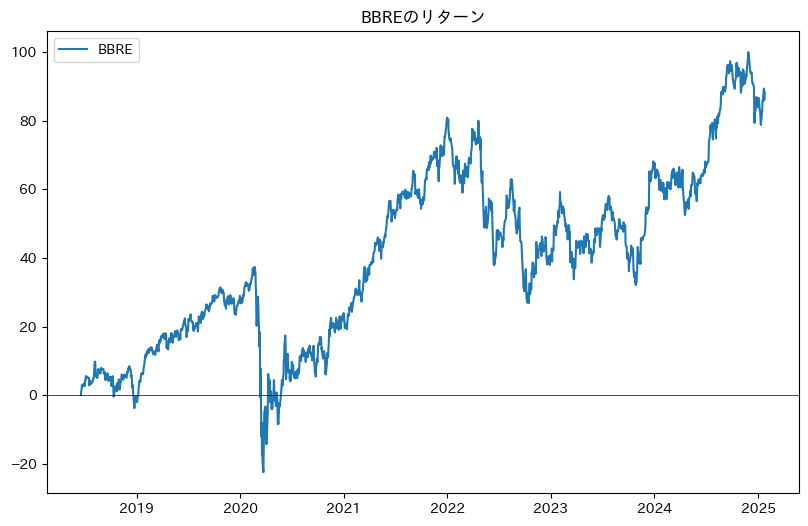

In [454]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(df['Date'], df['Return'], label=f'{ticker}')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title(f'{ticker}のリターン')
ax.legend()

## IFGL

In [447]:
ticker = 'IFGL'
tiskers = yf.Ticker(ticker)
# must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
historical_data = tiskers.history(period='max')

def get_close_and_dividends(data):
    df = pl.DataFrame({
        'Date': data.index,
        'Close': data['Close'],
        'Dividends': data['Dividends'],
    })
    return df


df = get_close_and_dividends(historical_data)
df = dividends_reinvestment_return(df, initial_shares=10000)

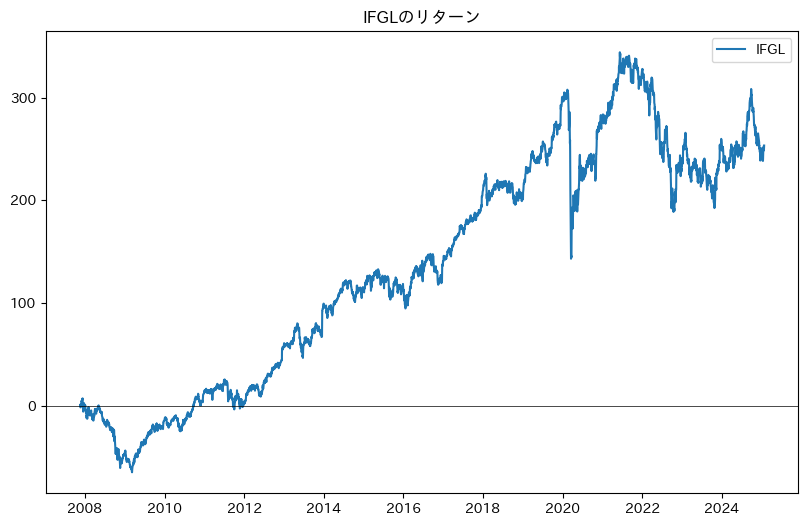

In [450]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(df['Date'], df['Return'], label=f'{ticker}')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title(f'{ticker}のリターン')
ax.legend()

## 比較

In [417]:
ticker = ['BBRE', 'IFGL']
tiskers = yf.Tickers(ticker)
historical_data = tiskers.history(period='max')
historical_data.dropna(inplace=True)

def get_close_and_dividends(data, ticker):
    df = pl.DataFrame({
        'Date': data.index,
        'Close': data['Close'][f'{ticker}'],
        'Dividends': data['Dividends'][f'{ticker}'],
    })
    return df


bbre = get_close_and_dividends(historical_data, ticker='BBRE')
bbre = dividends_reinvestment_return(bbre, initial_shares=10000)

ifgl = get_close_and_dividends(historical_data, ticker='IFGL')
ifgl = dividends_reinvestment_return(ifgl, initial_shares=10000)

[*********************100%***********************]  2 of 2 completed


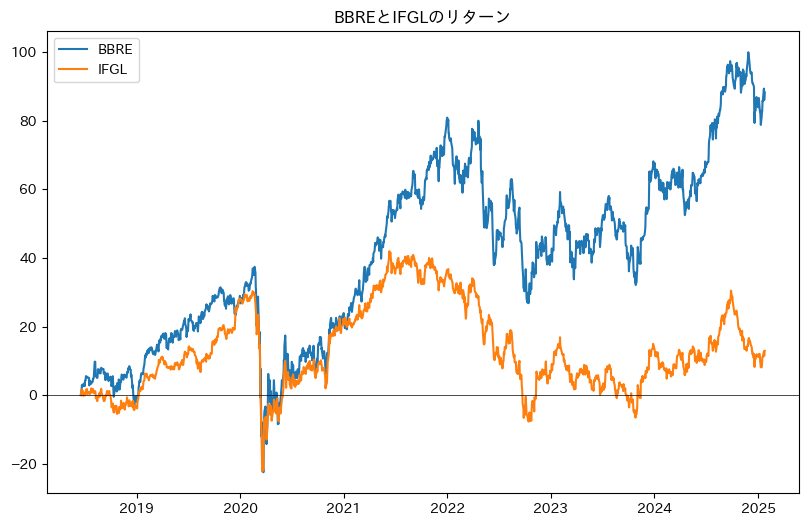

In [419]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(bbre['Date'], bbre['Return'], label='BBRE')
ax.plot(ifgl['Date'], ifgl['Return'], label='IFGL')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('BBREとIFGLのリターン')
ax.legend()

## Volatility

In [56]:
volatility_df = df.select([
    pl.col("us_reit_log_diff"),
    pl.col("ex_us_reit_log_diff"),
])

In [60]:
volatility_df

us_reit_log_diff,ex_us_reit_log_diff
f64,f64
0.0,0.0
0.005165,0.008622
0.009205,-0.014152
0.00431,-0.002726
0.010501,0.007478
…,…
-0.000779,0.0
0.019836,0.014411
-0.017969,-0.011822


In [57]:
volatility_df.std() * np.sqrt(252)

us_reit_log_diff,ex_us_reit_log_diff
f64,f64
0.240079,0.185878


$$
\text{variance} = w^{\top} \cdot \Sigma \cdot w
$$

- $w$: weight
- $\Sigma$: covariance matrix

In [90]:
from scipy.optimize import minimize

num_assets = 2

tmp = np.array([volatility_df['us_reit_log_diff'], volatility_df['ex_us_reit_log_diff']])
cov_matrix = np.cov(tmp)

def portfolio_variance(weights):
    var = weights.T @ cov_matrix @ weights
    return np.sqrt(var) * np.sqrt(252)

def constraint_sum_of_weights(weights):
    return np.sum(weights) - 1

constraints = [
    {"type": "eq", "fun": constraint_sum_of_weights}
]

initial_guess = np.ones(num_assets) / num_assets

bounds = [(0, 1) for _ in range(num_assets)]

result = minimize(portfolio_variance, initial_guess, constraints=constraints, bounds=bounds)

print(f"Optimal portfolio variance: {result.fun:.3%}")
print("Optimal portfolio weights")
print(f'BBRE: {result.x[0]:.2%}, IFGL: {result.x[1]:.2%}')

Optimal portfolio variance: 18.502%
Optimal portfolio weights
BBRE: 10.50%, IFGL: 89.50%
